In [1]:
# pip3 install torch torchvision torchaudio ##NO Cuda support
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold


import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets


# pip install ipywidgets
# jupyter nbextension enable --py widgetsnbextension
from tqdm.notebook import trange, tqdm
import time
from ipywidgets import FloatProgress

# Basics

In [2]:
# Torch is based around tensors (n-dimensional arrays of scalars)
## For this example, we use basic scalar tensors - but for a NN, you'll have larger arrays
## Here we cast to double to match python's float64 (by default, pytorch uses float32)
## By default, pytorch assumes leaf nodes do not require gradients (in most common cases, they do not) - set to True for now

## Define some Tensor values
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Do a forward pass of the 'o' function
print(o.data.item()) ##forward pass
# Do a backward pass to calculate gradients for all the Tensors
o.backward() ##backpropagate

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


# A Neural Net

Tutorial: https://colab.research.google.com/github/bentrevett/pytorch-image-classification/blob/master/1_mlp.ipynb#scrollTo=yqzZus6a24_c

## Load some data (mnist)

In [3]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
# Load MNIST data
ROOT = "../data/"

train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True)

In [5]:
mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255
print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


## Initialize transforms (data processing/augmentation)

In [6]:
train_transforms = transforms.Compose([
                            transforms.RandomRotation(5, fill=(0,)),
                            transforms.RandomCrop(28, padding=2),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[mean], std=[std])
                                      ])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[mean], std=[std])
                                     ])

# Reload data with transforms
train_data = datasets.MNIST(root=ROOT,
                            train=True,
                            download=True,
                            transform=train_transforms)

test_data = datasets.MNIST(root=ROOT,
                           train=False,
                           download=True,
                           transform=test_transforms)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 60000
Number of testing examples: 10000


In [7]:
# Validation data
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = torch.utils.data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])
                                           
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


We don't want the validation data to include the augmentation transforms included in the training data, since we want it to emulate the test data. 
We can simply replace the validation set's transform by overwriting it with our test transforms from above.

As the validation set is a `Subset` of the training set, if we change the transforms of one, then by default Torchvision will change the transforms of the other. To stop this from happening, we make a `deepcopy` of the validation data.

In [8]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [9]:
# Define a DataLoader for each of the training/validation/test sets. 
# We can iterate over these, and they will yield batches of images and labels which we can use to train our model.
# We only need to shuffle our training set.
BATCH_SIZE = 64

train_iterator = torch.utils.data.DataLoader(train_data,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = torch.utils.data.DataLoader(valid_data,
                                 batch_size=BATCH_SIZE)

test_iterator = torch.utils.data.DataLoader(test_data,
                                batch_size=BATCH_SIZE)

## Define the model, optimizer, and loss

In [19]:
class MLP(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        # 2 Hidden layers (one fully connected to input, the next fully connected to that and then the output)
        self.input_fc = torch.nn.Linear(input_dim, 250) 
        self.hidden_fc = torch.nn.Linear(250, 100)
        self.output_fc = torch.nn.Linear(100, output_dim)
    
    def forward(self, x):
        # x = [batch_size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        h_1 = torch.nn.functional.relu(self.input_fc(x))     ##input shape: x = batch size, height*width
        h_2 = torch.nn.functional.relu(self.hidden_fc(h_1))  ##input shape: h_1 = batch size, 250
        y_pred = self.output_fc(h_2)                         ##input shape: h_2 = batch size, 100 

        return y_pred, h_2 ##return the intermediate layer for inspection if desired

def count_parameters(model):
    "Simple function to count parameters in model"
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [20]:
INPUT_DIM = 28 * 28
OUTPUT_DIM = 10

# Instantiate the model
model = MLP(INPUT_DIM, OUTPUT_DIM)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [21]:
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

# Define a *criterion*, PyTorch's name for a loss function
## This function both computes the softmax activation fn (note we didn't apply that in the model fn)
## and calculates the loss 
criterion = torch.nn.CrossEntropyLoss()


# 'Device' is used to place your model and data on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")

# place model and criterion on device
model = model.to(device)
criterion = criterion.to(device)

device: cpu


## Training Loop

In [26]:
def train(model, iterator, optimizer, criterion, device):
    """
    Training loop - for one epoch, train the model on batches of data. 
    Forward pass, calc loss, backward pass, update params with optimizer.
    """
    epoch_loss = 0
    epoch_acc = 0

    # Put model into training mode
    ## Some layers act differently when training and evaluating the model that contains them, hence why we must tell our model we are in "training" mode
    model.train()

    # iterate over our dataloader, returning batches of (image, label)
    for (x, y) in tqdm(iterator, desc="Training", leave=False):
        x = x.to(device) ##place batch on GPU if you have one
        y = y.to(device)

        optimizer.zero_grad() ##clear the gradients calculated from the last batch
        
        # FORWARD
        ## pass our batch of images, `x`, through to model to get predictions, `y_pred`
        y_pred, _ = model(x)
        # use predictions to calc loss and acc
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        
        # BACKWARD
        ## perform backprop to calc gradients
        loss.backward()

        # update the parameters by taking an optimizer step
        optimizer.step()

        # update metrics
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
    # average loss and accuracy over the total number of steps in the iterator (ie, the number of batches per epoch)
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    """
    Evaluation loop - pass in batches of data and evaluate the model's predictions. 
    No backprop/gradient calculation/param updates
    """
    epoch_loss = 0
    epoch_acc = 0

    # Put model in evaluation mode
    model.eval()

    # `torch.no_grad()` ensures that gradients are not calculated for whatever is inside the `with` block. 
    # As our model will not have to calculate gradients, it will be faster and use less memory. 
    with torch.no_grad():
        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):
            x = x.to(device)
            y = y.to(device)
            # FORWARD PASS
            y_pred, _ = model(x)
            # EVALUATE
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def epoch_time(start_time, end_time):
    "Small function to tell us how long an epoch took"
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def weight_reset(m):
    """
    Function to reset all weights in the layers (note, it only looks for Linear layers, 
    have to expand if including other layers
    """
    if isinstance(m, torch.nn.Linear): #or isinstance(m, nn.Conv2d):
        m.reset_parameters()
        
def weights_init(m):
    "Could use this function to initialize weights in a specific way (not used in this tutorial)"
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)



model.apply(weight_reset) ##applies through all layers
# or for ex, model.apply(weights_init) to reset to randomly intialized 

MLP(
  (input_fc): Linear(in_features=784, out_features=250, bias=True)
  (hidden_fc): Linear(in_features=250, out_features=100, bias=True)
  (output_fc): Linear(in_features=100, out_features=10, bias=True)
)

In [27]:
EPOCHS = 3
best_valid_loss = float('inf')

for epoch in trange(EPOCHS):
    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tutorial-model-ex.pt')
    
    end_time = time.monotonic()

    epoch_mins,epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/3 [00:00<?, ?it/s]

Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 0.383 | Train Acc: 87.95%
	 Val. Loss: 0.135 |  Val. Acc: 95.83%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 23s
	Train Loss: 0.162 | Train Acc: 95.07%
	 Val. Loss: 0.118 |  Val. Acc: 96.05%


Training:   0%|          | 0/844 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/94 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 23s
	Train Loss: 0.128 | Train Acc: 95.98%
	 Val. Loss: 0.087 |  Val. Acc: 97.25%


In [29]:
# Load the parameters of the model that achieved best validation loss
model.load_state_dict(torch.load('tutorial-model-ex.pt'))

# Pass in the test data
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/157 [00:00<?, ?it/s]

Test Loss: 0.076 | Test Acc: 97.40%


# Predictions

In [30]:
def get_predictions(model, iterator, device):
    """
    Iterate through batches of the test data, pass data through model, get predictions.
    Apply softmax to get predicted probabilities.
    Store the images, predicted labels, and predicted probabilities.
    NOTE: labels = the true labels, which are known in this specific case
    """

    # Ensure model is in eval mode
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x,y) in iterator:
            x = x.to(device)

            y_pred, _ = model(x)
            y_prob = torch.nn.functional.softmax(y_pred, dim=-1)
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [31]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [43]:
# Test accuracy 
torch.sum(pred_labels == labels) / len(labels)

tensor(0.9739)

# Examining the model

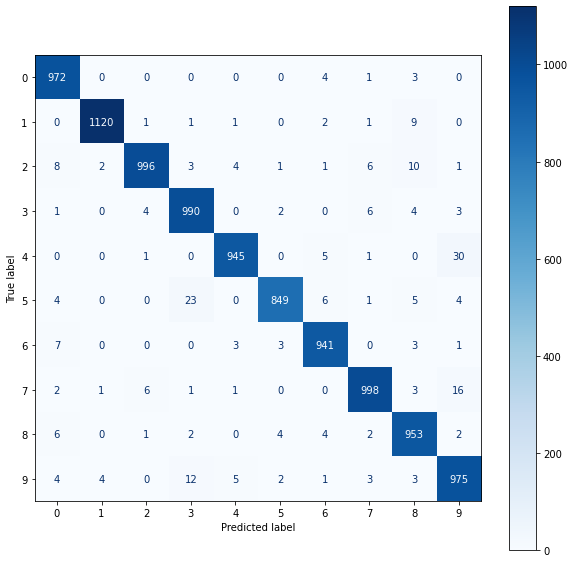

In [48]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

plot_confusion_matrix(labels, pred_labels)

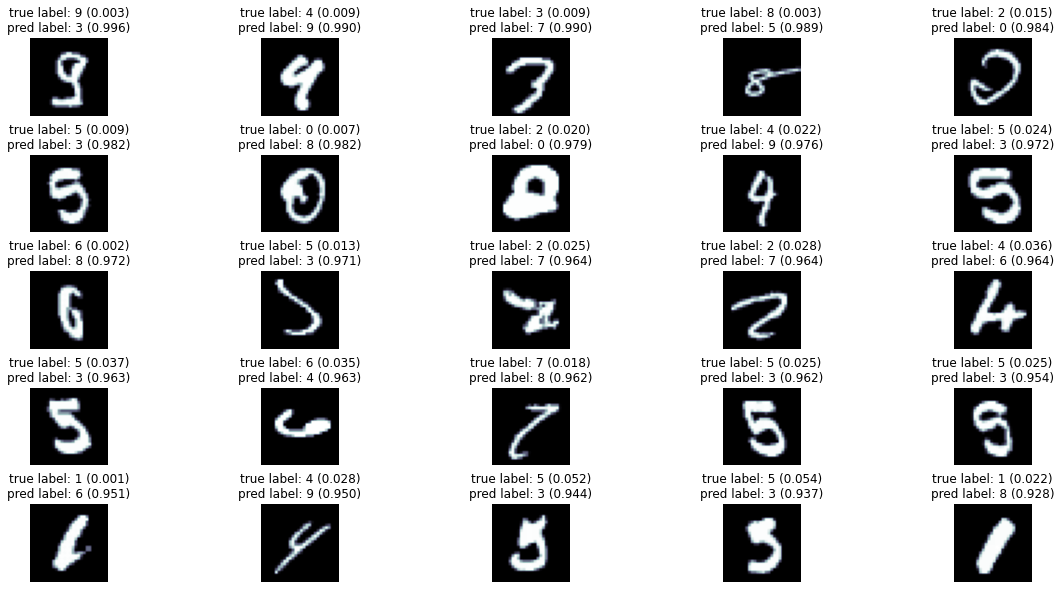

In [58]:
corrects = torch.eq(labels, pred_labels)

incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse=True,
                        key=lambda x: torch.max(x[2], dim=0).values)


def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim=0)
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n'
                     f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
        ax.axis('off')
    fig.subplots_adjust(hspace=0.5)

plot_most_incorrect(incorrect_examples, 25)

In [60]:
def get_representations(model, iterator, device):
    "Get output & intermediate representations of images from the model to try and visualize"
    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():
        for (x, y) in tqdm(iterator):
            x = x.to(device)
            # forward pass
            y_pred, h = model(x)

            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim=0)
    intermediates = torch.cat(intermediates, dim=0)
    labels = torch.cat(labels, dim=0)

    return outputs, intermediates, labels

outputs, intermediates, labels = get_representations(model,
                                                     train_iterator,
                                                     device)

  0%|          | 0/844 [00:00<?, ?it/s]

In [61]:
# Use PCA to reduce dimensionality of the data we want to visualize
def get_pca(data, n_components=2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

def plot_representations(data, labels, n_images=None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c=labels, cmap='tab10')
    handles, labels = scatter.legend_elements()
    ax.legend(handles=handles, labels=labels)

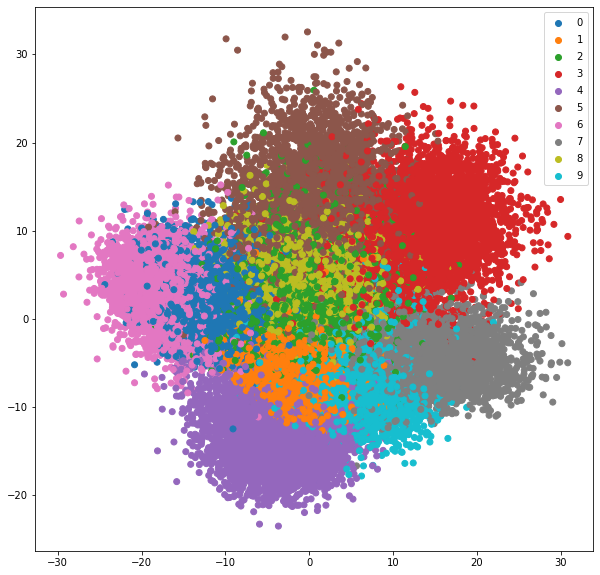

In [62]:
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)

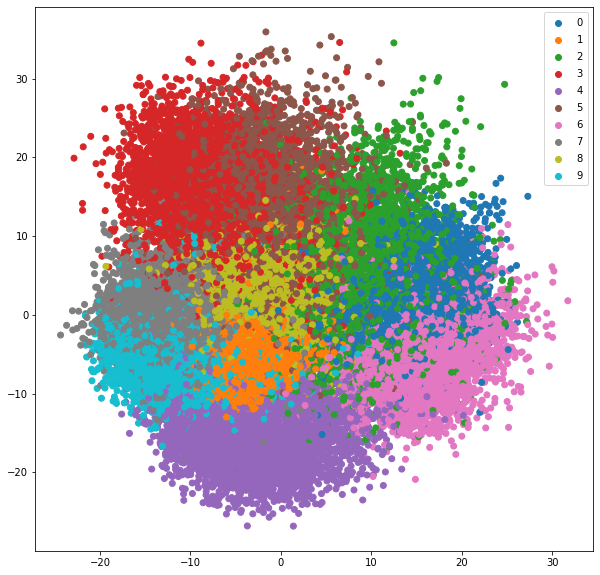

In [63]:
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

Alternative to PCA is  t-SNE (t-distributed stochastic neighbor embedding).
t-SNE is very slow, so we only compute it on a subset of the representations.

The classes look very well separated, and it is possible to use on this representation to achieve decent accuracy.

c:\Users\hanse\Documents\python\projects\python-ml\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanse\Documents\python\projects\python-ml\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


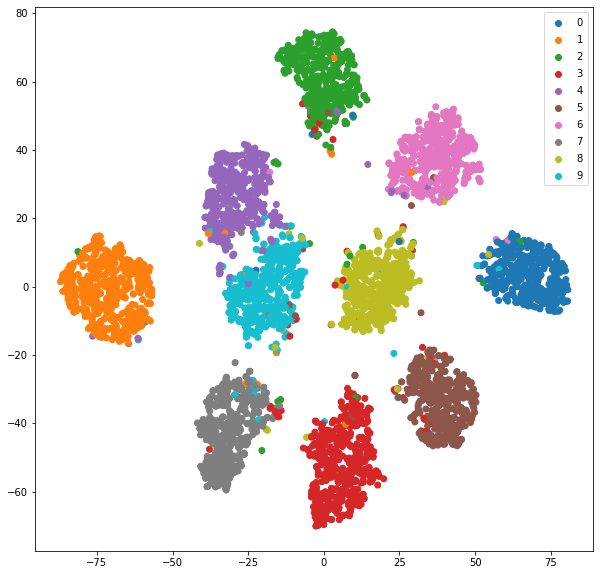

In [64]:
def get_tsne(data, n_components=2, n_images=None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components=n_components, random_state=0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

N_IMAGES = 5000

# OUTPUT REPRESENTATIONS
output_tsne_data = get_tsne(outputs, n_images=N_IMAGES)
plot_representations(output_tsne_data, labels, n_images=N_IMAGES)

c:\Users\hanse\Documents\python\projects\python-ml\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\hanse\Documents\python\projects\python-ml\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


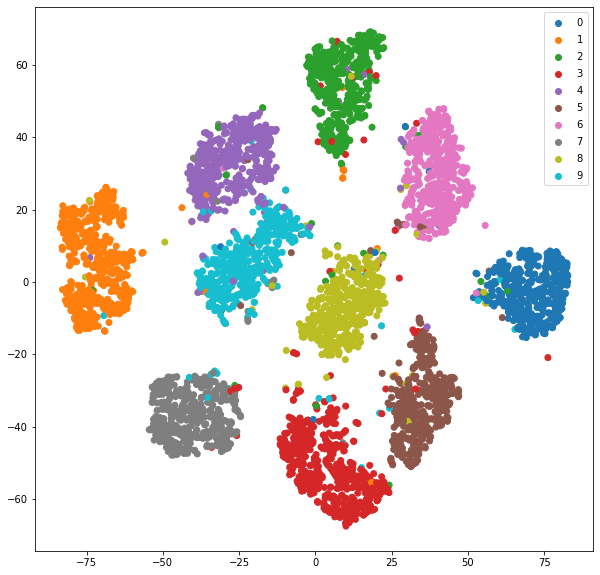

In [65]:
# INTERMEDIATE REPRESENTATIONS

intermediate_tsne_data = get_tsne(intermediates, n_images=N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images=N_IMAGES)

We could also try to generate fake digits by repeatedly generating noise and feeding it through the model. It will find the most confidently generated digit for the desired class.

In [67]:
def imagine_digit(model, digit, device, n_iterations=50_000):

    model.eval()

    best_prob = 0
    best_image = None

    with torch.no_grad():

        for _ in trange(n_iterations):

            x = torch.randn(32, 28, 28).to(device)

            y_pred, _ = model(x)

            preds = torch.nn.functional.softmax(y_pred, dim=-1)

            _best_prob, index = torch.max(preds[:, digit], dim=0)

            if _best_prob > best_prob:
                best_prob = _best_prob
                best_image = x[index]

    return best_image, best_prob

# Try to produce a 3
DIGIT = 3
best_image, best_prob = imagine_digit(model, DIGIT, device)

  0%|          | 0/50000 [00:00<?, ?it/s]

Best image probability: 99.83%


(-0.5, 27.5, 27.5, -0.5)

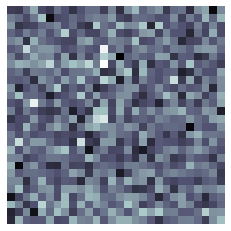

In [70]:
print(f'Best image probability: {best_prob.item()*100:.2f}%')

plt.imshow(best_image.cpu().numpy(), cmap='bone') ##i can kind of see a 3 in there
plt.axis('off') 

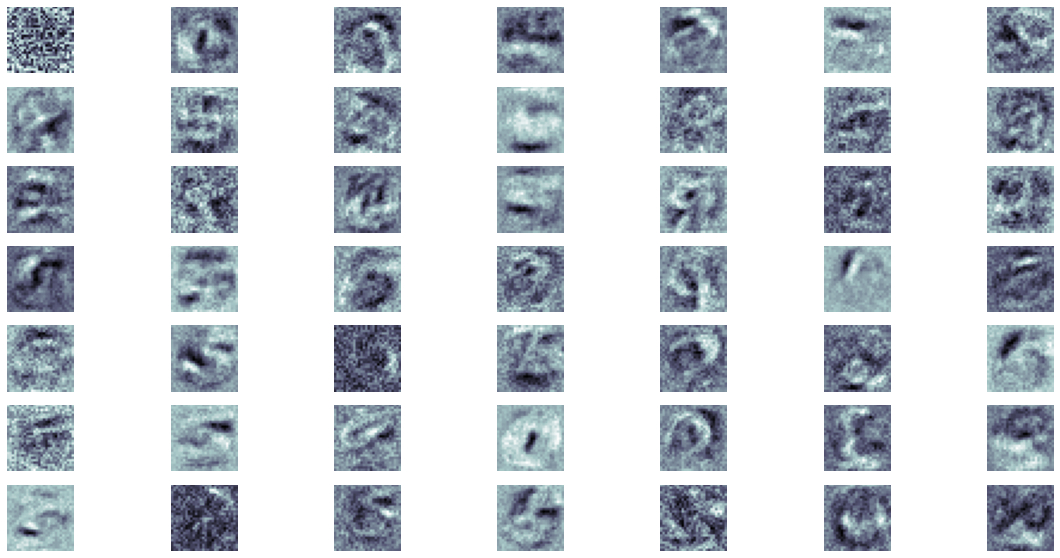

In [72]:
# INSPECTING THE WEIGHTS 
def plot_weights(weights, n_weights):

    rows = int(np.sqrt(n_weights))
    cols = int(np.sqrt(n_weights))

    fig = plt.figure(figsize=(20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='bone')
        ax.axis('off')

N_WEIGHTS = 50
weights = model.input_fc.weight.data ##the first layer (often thought to do major feature representations)
plot_weights(weights, N_WEIGHTS)